# TXx UNSEEN trends in the MPI-ESM1-2-HR hindcast

Melbourne temperature extremes (TXx; annual maximum).


In [2]:
%load_ext autoreload
%autoreload 2

from datatree import DataTree
import glob
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoLocator, AutoMinorLocator
import numpy as np
from pathlib import Path
from scipy.stats import genextreme
import xarray as xr

from unseen.fileio import open_dataset, open_mfforecast, to_zarr
from unseen import independence, stability, moments, eva


/g/data/xv83/as3189/conda/envs/unseen/lib/python3.11/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [3]:
home = Path("/g/data/xv83/unseen-projects/outputs/hazards")
model = "MPI-ESM1-2-HR"
index = "TXx"
var = "tasmax"
var_agcd = "tmax"
time_freq = "YE-JUN"
timescale = "annual-jul-to-jun"
units = "Temperature [°C]"

name = "Melbourne"
coords = [-37.81, 144.96]

### Observational Data (AGCD)


In [4]:
%%time
outfile_agcd = home / f"data/{index.lower()}_AGCD-CSIRO_s1910-2023_{timescale}_{name.lower()}.zarr.zip"

if outfile_agcd.exists():
    ds_agcd = xr.open_dataset(outfile_agcd, engine='zarr')
else:
    # AGCD Observations (~16min)
    agcd_files = glob.glob(f"/g/data/xv83/agcd-csiro/{var_agcd}/daily/{var_agcd}_AGCD-CSIRO_r005*.nc")
    agcd_files.sort()

    ds_agcd = open_dataset(
        agcd_files,
        variables=[var],
        point_selection=coords,
        time_agg="max",
        time_freq=time_freq,
        input_freq="D",
        time_agg_dates=True,
        reset_times=True,
        time_agg_min_tsteps=360,
        metadata_file="/g/data/xv83/unseen-projects/code/dataset_config/dataset_agcd_daily.yml",
        verbose=False,
    )

    # Save dataset (~15mins)
    to_zarr(ds_agcd, str(outfile_agcd))
ds_agcd


CPU times: user 88.5 ms, sys: 94.7 ms, total: 183 ms
Wall time: 544 ms


<xarray.Dataset> Size: 6kB
Dimensions:     (time: 113)
Coordinates:
  * time        (time) datetime64[ns] 904B 1911-01-01T09:00:00 ... 2023-01-01...
Data variables:
    event_time  (time) <U10 5kB ...
    tasmax      (time) float32 452B ...
Attributes: (12/33)
    CDI:                           Climate Data Interface version ?? (http://...
    CDO:                           Climate Data Operators version 1.7.0 (http...
    Conventions:                   CF-1.6
    acknowledgment:                The Australian Government, Bureau of Meteo...
    analysis_components:           mean: the gridded temperature value
    bom-cmp-awap_version:          bom-cmp-awap-1.00-100.1.x86_64
    ...                            ...
    summary:                       The daily maximum temperature station data...
    time_coverage_end:             1910-01-02T09:00:00
    time_coverage_start:           1910-01-01T09:00:00
    title:                         Interpolated Mean Maximum Temperature
    url:                           http://www.bom.gov.au/climate/
    uuid:                          91a1ecc4-e45e-47b7-8309-a9794abef032

### Model Data


In [4]:
%%time
outfile = home / f"data/{index.lower()}_{model}_dcppA-hindcast_**_{timescale}_{name.lower()}.zarr.zip"

if outfile.exists():
    ds = xr.open_mfdataset(str(outfile), engine='zarr')
else:
    ds = open_mfforecast(
        f"/g/data/xv83/unseen-projects/code/file_lists/{model}_dcppA-hindcast_{var}_files.txt", 
        n_time_files=1,
        n_ensemble_files=10,
        variables=[var],
        point_selection=coords,
        time_freq=time_freq,
        time_agg="max",
        input_freq="D",
        time_agg_dates=True,
        reset_times=True,
        time_agg_min_tsteps=360,
        verbose=False,
    )
    to_zarr(ds, str(outfile))
ds


# Open pre-saved txx


In [ ]:
agcd_outfile = (
    home / f"data/{index.lower()}_AGCD-CSIRO_r05_1910-2023_{timescale}_aus.nc"
)
outfile = (
    home
    / f"data/{index.lower()}_{model}-dcppA-hindcast_196011-201811_{timescale}_aus.nc"
)

ds_agcd = xr.open_dataset(str(agcd_outfile), use_cftime=True)
ds = xr.open_dataset(str(outfile), use_cftime=True)

# Select the coordinate
ds = ds.sel(lat=coords[0], lon=coords[1], method="nearest", drop=True)
ds_agcd = ds_agcd.sel(lat=coords[0], lon=coords[1], method="nearest", drop=True)
ds

In [6]:
# Drop AGCD years before model data is available
ds_agcd = ds_agcd.where(ds_agcd.time.dt.year >= ds.time.dt.year.min(), drop=True)

data_agcd = ds_agcd[var]
data_agcd

ds = ds[var].dropna("lead_time", how="all").persist()

# Stability and independence testing


/g/data/e14/as3189/conda/envs/unseen/lib/python3.10/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/g/data/e14/as3189/conda/envs/unseen/lib/python3.10/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


CPU times: user 4min 35s, sys: 5.01 s, total: 4min 40s
Wall time: 8min 10s


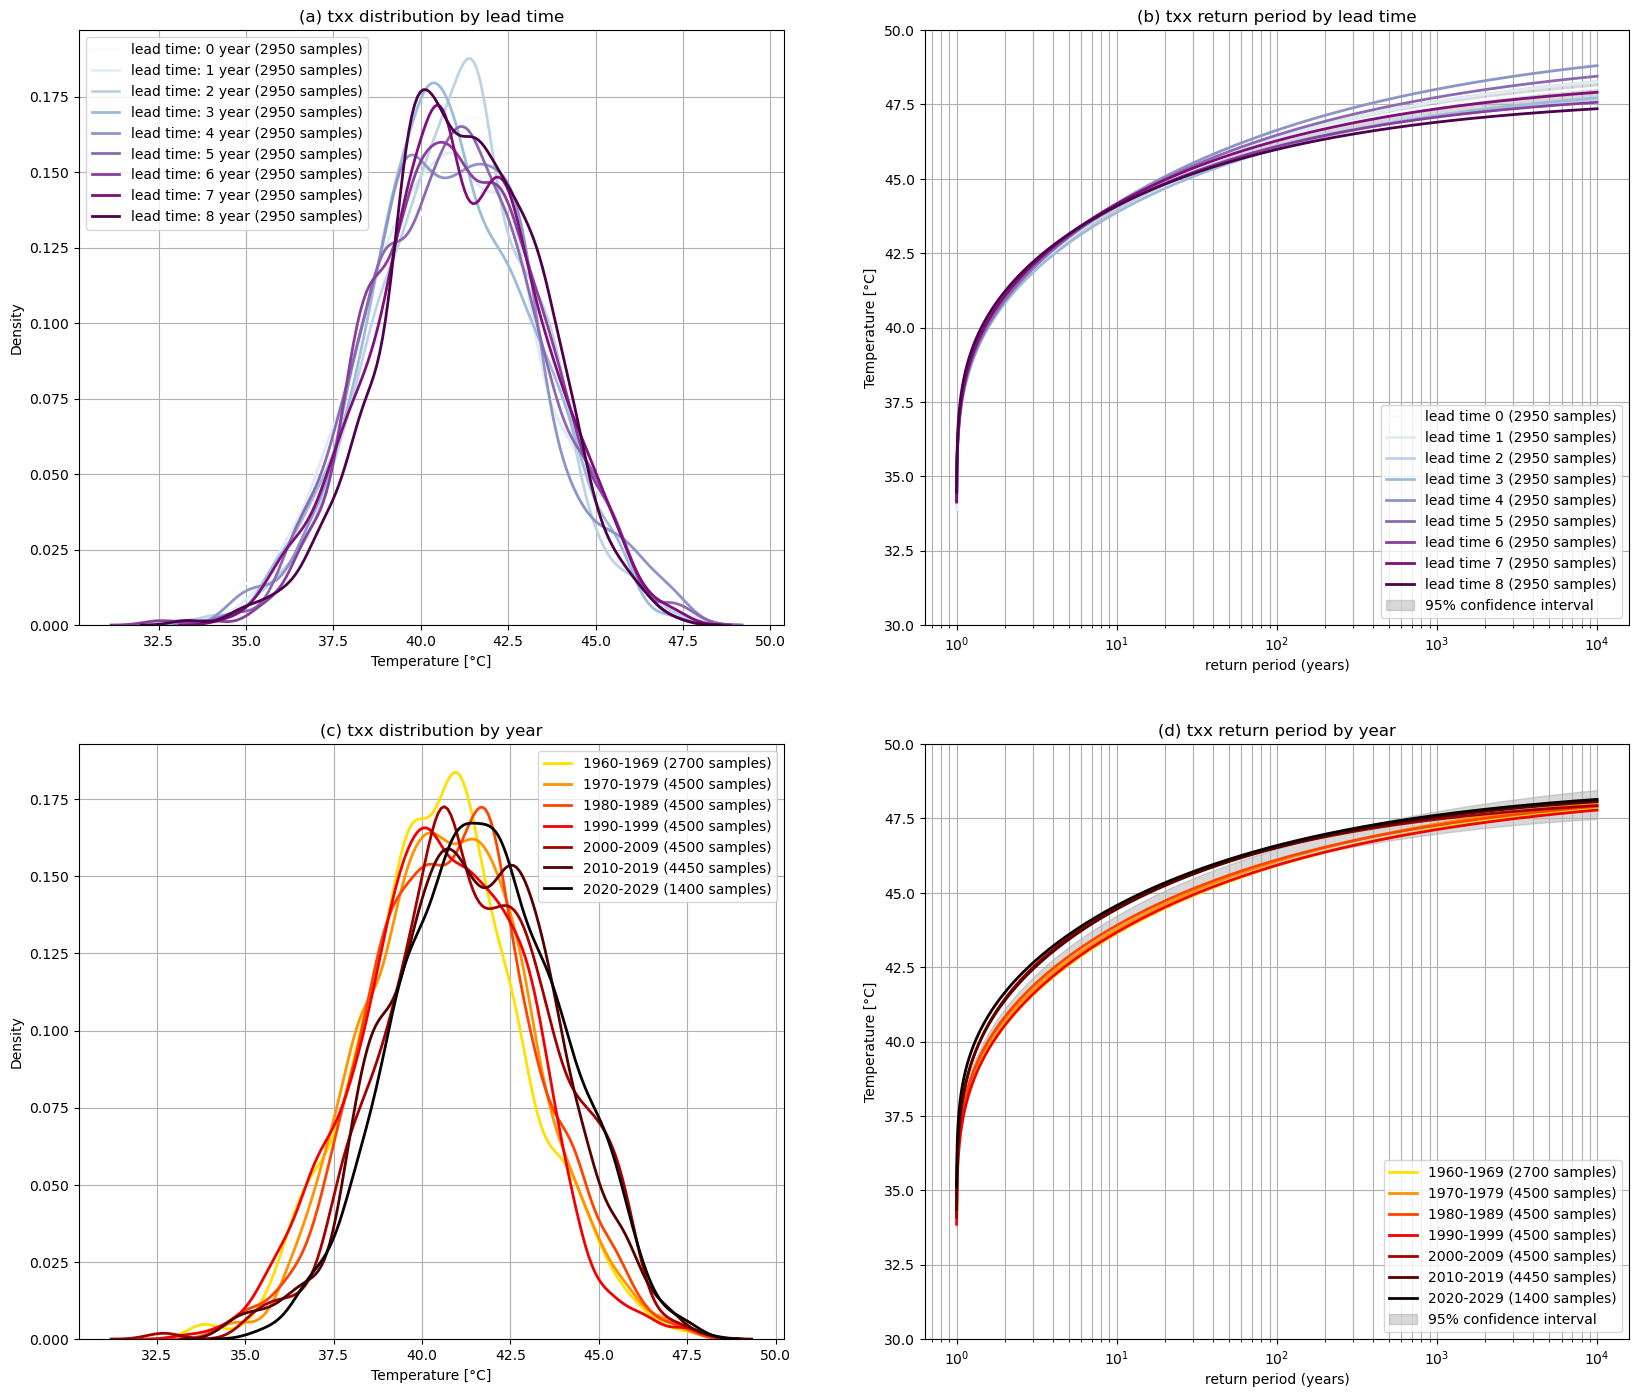

In [15]:
%%time

stability.create_plot(
    ds,
    index,
    [1960, 1970, 1980, 1990, 2000, 2010, 2020],
    uncertainty=True,
    return_method='gev',
    units='Temperature [°C]',
    outfile=str(home / f"figures/{index.lower()}_stability_{name.lower()}_{model}.png"),
)


CPU times: user 5.83 s, sys: 42.5 ms, total: 5.88 s
Wall time: 6.52 s


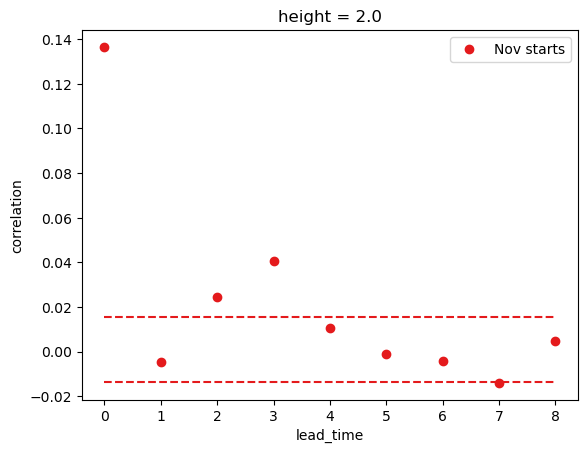

In [17]:
%%time

mean_correlations, null_correlation_bounds = independence.run_tests(ds)
independence.create_plot(
    mean_correlations,
    null_correlation_bounds,
    str(home / f"figures/{index.lower()}_independence_{name.lower()}_{model}.png"),
)


In [13]:
# Drop dependent lead times (drop if before the first lead_time within the bounds)
month = 11
mask = (mean_correlations[month] >= null_correlation_bounds[month][0]) & (
    mean_correlations[month] <= null_correlation_bounds[month][1]
)
min_lead_time = np.arange(mean_correlations[month].size)[mask].min()

data = ds.isel(lead_time=slice(min_lead_time, -1), drop=True)

### Statistics

INFO:root:mean: Obs = 39.88875198364258, Model 95% CI =40.39432382583618 to 41.5787392616272
INFO:root:standard deviation: Obs = 2.192502737045288, Model 95% CI =1.9486294209957122 to 2.697091406583786
INFO:root:skew: Obs = 0.5645487995177804, Model 95% CI =-0.5454169754198781 to 0.5033158255557036
INFO:root:kurtosis: Obs = 0.0013192655770541961, Model 95% CI =-0.8790082283701607 to 0.8228143356047725
INFO:root:GEV shape: Obs = 0.09404475134900585, Model 95% CI =0.1249530745606537 to 0.48029050708382326
INFO:root:GEV location: Obs = 38.946611617926806, Model 95% CI =39.531737764885605 to 40.83695247994782
INFO:root:GEV scale: Obs = 1.8963493928988848, Model 95% CI =1.8627075329410716 to 2.779098429220542


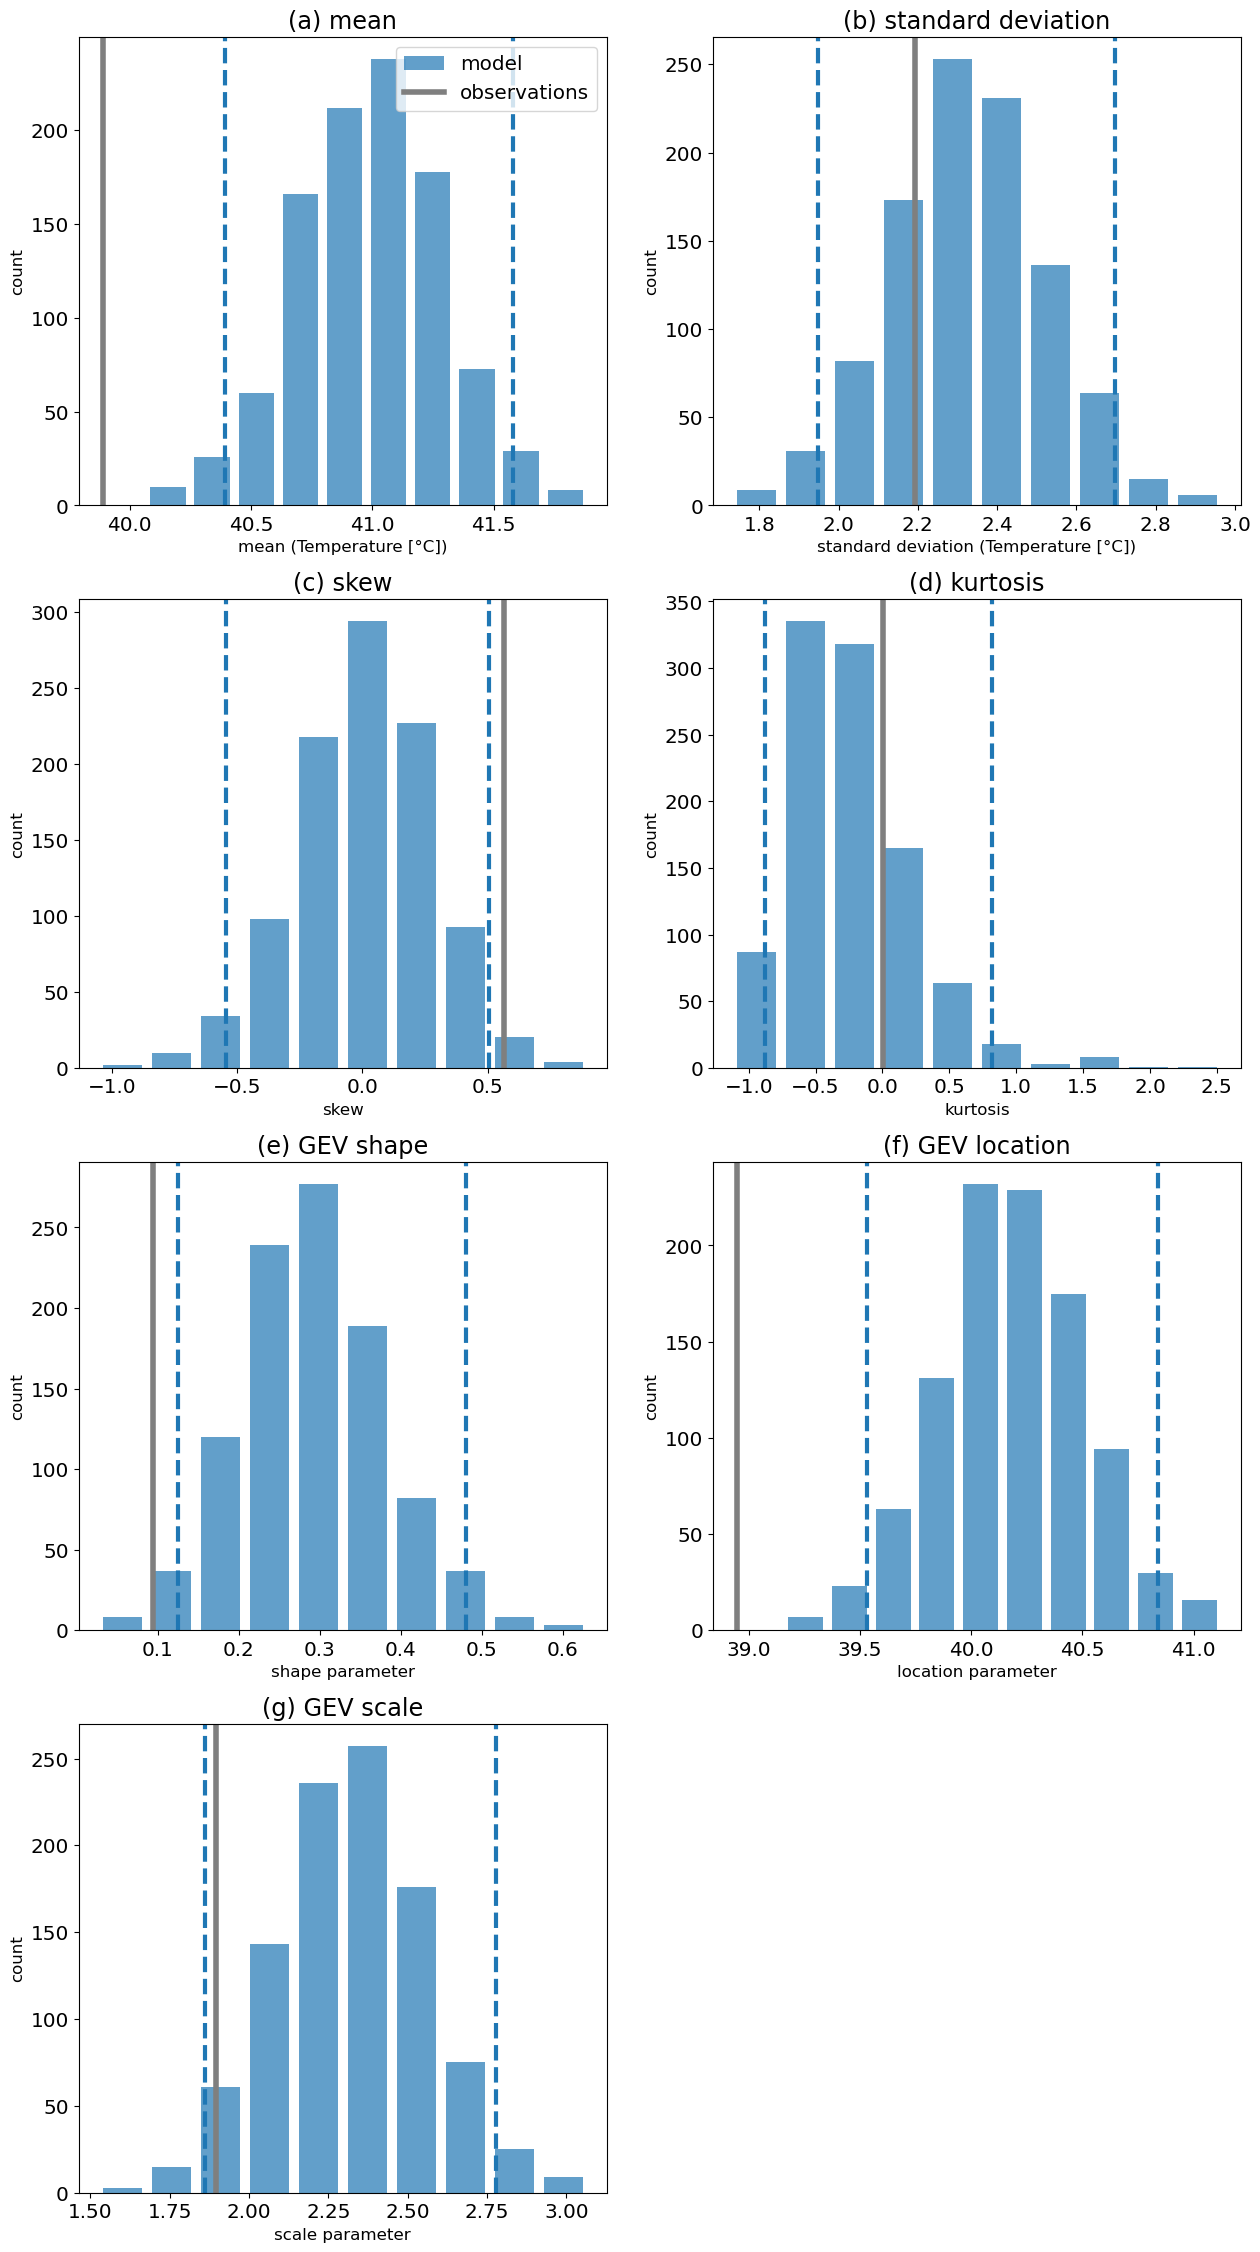

In [8]:
data = ds.isel(lead_time=slice(1, -1), drop=True)
moments.create_plot(
    data,
    data_agcd,
    da_bc_fcst=None,
    outfile=None,
    units=units,
    ensemble_dim="ensemble",
    init_dim="init_date",
    lead_dim="lead_time",
    infile_logs=None,
)

### Seasonality

In [ ]:
model_df = da_stacked.to_dataframe()
model_df = model_df.dropna()

event_months = [int(date[5:7]) for date in model_df["event_time"].values]
event_years = [int(date[0:4]) for date in model_df["event_time"].values]

month_counts = Counter(event_months)
months = np.arange(1, 13)
counts = [month_counts[month] for month in months]

plt.bar(months, counts)
plt.title(f"{metric} timing for {region_name} ({model_name})")
plt.ylabel("number of events")
plt.xlabel("month")
xlabels = [calendar.month_abbr[i] for i in months]
plt.xticks(months, xlabels)
# outfile = f'/g/data/xv83/unseen-projects/outputs/tc-jasper/figures/{metric}_timing_{model_name}_{region_name}.png'
# print(outfile)
# plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
plt.show()

# Plots


In [14]:
da_stacked = data.stack({"sample": ["ensemble", "init_date", "lead_time"]})

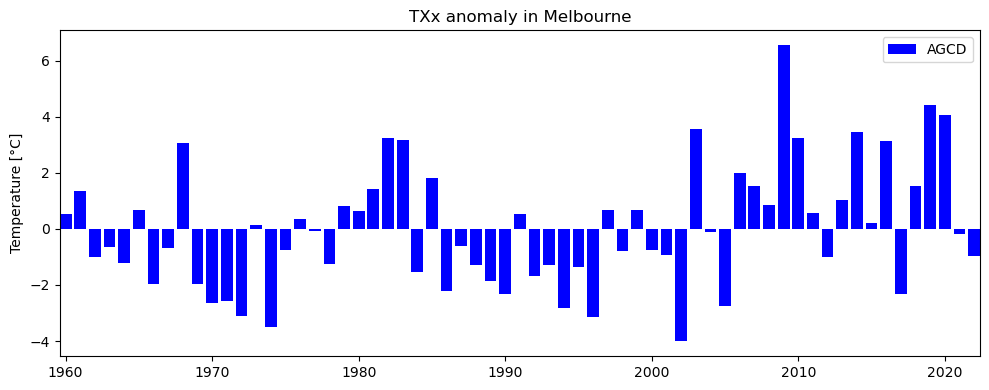

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.set_title(f"{index} anomaly in {name}")
ax.bar(data_agcd.time.dt.year, data_agcd - data_agcd.mean(), color="b", label="AGCD")
ax.set_xmargin(0)
ax.set_ylabel(units)
ax.legend()
plt.tight_layout()
plt.savefig(
    home / f"figures/{index.lower()}_timeseries_{name.lower()}_AGCD.png",
    dpi=200,
    bbox_inches="tight",
)

CPU times: user 776 ms, sys: 3.04 ms, total: 779 ms
Wall time: 1.9 s


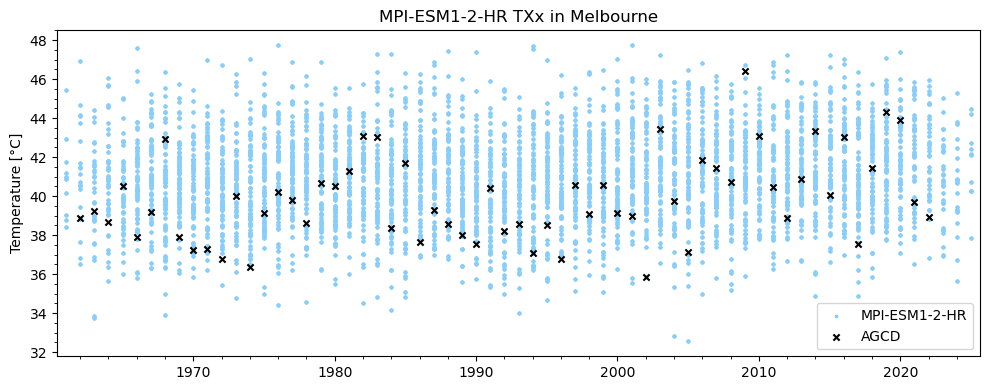

In [19]:
%%time 

# AGCD & model time series (scatter)
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.set_title(f"{model} {index} in {name}")

ax.scatter(da_stacked.time.dt.year, da_stacked, s=3, c="lightskyblue", label=model)

# Plot AGCD data (excluding years earlier than the model)
mask = data_agcd.time.dt.year > da_stacked.time.dt.year.min()
ax.scatter(
    data_agcd.time.dt.year[mask], data_agcd[mask], s=20, c="k", marker="x", label="AGCD"
)

ax.set_ylabel(units)
ax.set_xmargin(1e-2)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.legend()
plt.tight_layout()
plt.savefig(
    home / f"figures/{index.lower()}_timeseries_{name.lower()}_{model}.png",
    dpi=200,
    bbox_inches="tight",
)


CPU times: user 1.29 s, sys: 5.98 ms, total: 1.3 s
Wall time: 5.05 s


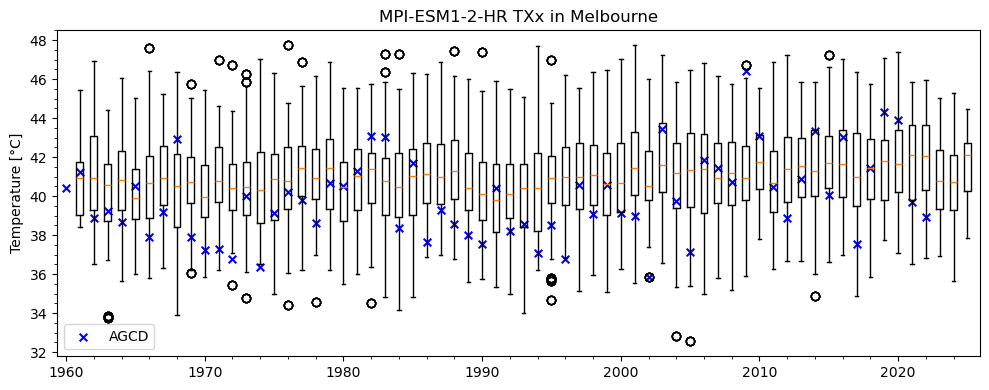

In [20]:
%%time 
# Model box and whiskers time series

# Group model data by year
dx = data.copy()
dx.coords["time"] = dx.time.dt.year
dx["init_date"] = dx.init_date.dt.year
dx = dx.stack({"sample": ["ensemble", "init_date", "lead_time"]})
dx = [dx.isel(sample=v) for k, v in dx.groupby(dx.time).groups.items()]

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

# Model box and whiskers
ax.boxplot(dx, positions=np.unique(data.time.dt.year), manage_ticks=False)

# AGCD blue crosses
ax.scatter(data_agcd.time.dt.year, data_agcd, s=30, c="b", marker="x", label="AGCD")

ax.set_title(f"{model} {index} in {name}")
ax.set_ylabel(units)
ax.set_xmargin(1e-2)
ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.legend()

plt.tight_layout()
plt.savefig(
    home / f"figures/{index.lower()}_timeseries_boxplot_{name.lower()}_{model}.png",
    dpi=200,
    bbox_inches="tight",
)


# Distribution parameters

## AGCD


In [21]:
# Stationary parameters
theta_s_agcd = eva.fit_gev(data_agcd, stationary=True, core_dim="time")
theta_s_agcd

array([ 0.08905715, 38.93402079,  1.87546382])

In [22]:
# Nonstationary parameters
# todo: use similar data years to the model??
covariate_agcd = data_agcd.time.dt.year
theta_agcd = eva.fit_gev(
    data_agcd, covariate=covariate_agcd, stationary=False, core_dim="time"
)
theta_agcd = xr.DataArray(theta_agcd, dims="theta")
theta_agcd

<xarray.DataArray (theta: 5)> Size: 40B
array([ 1.50571665e-01, -1.74094491e+01,  2.83441090e-02,  2.58643000e-07,
        9.47631876e-04])
Dimensions without coordinates: theta

## Model


In [23]:
# Stationary parameters
theta_s = eva.fit_gev(da_stacked, stationary=True, core_dim="sample")
theta_s

array([ 0.27006689, 40.13220821,  2.3417064 ])

In [24]:
# Nonstationary parameters
covariate = da_stacked.time.dt.year
theta = eva.fit_gev(
    da_stacked, covariate=covariate, stationary=False, core_dim="sample"
)
theta = xr.DataArray(theta, dims="theta")
theta

<xarray.DataArray (theta: 5)> Size: 40B
array([ 2.66706873e-01,  7.93101163e+00,  1.61581874e-02,  2.80788200e+00,
       -2.42976756e-04])
Dimensions without coordinates: theta

### Plot nonstationary PDFs and return curves (for a subset of years)


In [25]:
# Years to show
x = np.arange(covariate.min(), data_agcd.time.dt.year.max())
x = x[:: x.size // 6]
x = xr.DataArray(x, dims="time")
print(x)

# x_agcd = covariate_agcd.values[::covariate_agcd.size // x.size]
# x_agcd = xr.DataArray(x_agcd, dims='time')
# print(x_agcd)

<xarray.DataArray (time: 7)> Size: 56B
array([1961, 1971, 1981, 1991, 2001, 2011, 2021])
Dimensions without coordinates: time


## Histogram and PDFs


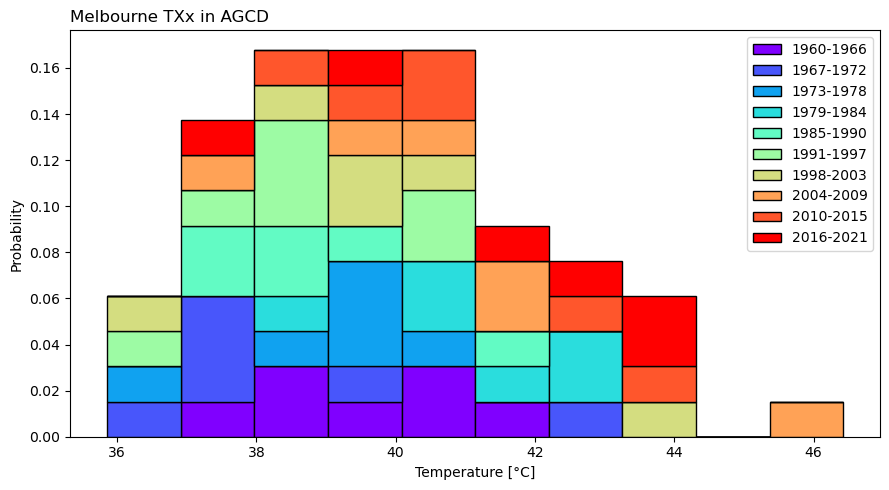

matplotlib.axes._axes.Axes

In [40]:
# Stacked histogram
dv1 = data_agcd.copy()
dv1.coords["time"] = dv1.time.dt.year.values.astype(dtype=int)
dim = "time"
dv2 = covariate_agcd
bins = np.histogram_bin_edges(dv2)
bins = np.ceil(bins).astype(dtype=int)
labels = [f"{bins[i]}-{bins[i+1] - 1}" for i in range(len(bins) - 1)]

fig, ax = plt.subplots(1, 1, figsize=(9, 5))
ax.set_title(f"{name} TXx in AGCD", loc="left")
ax = eva.plot_stacked_histogram(ax, dv1, dv2, bins, labels, dim="time")
ax.set_xlabel(f"Temperature [{data.attrs['units']}]")
plt.tight_layout()
plt.show()

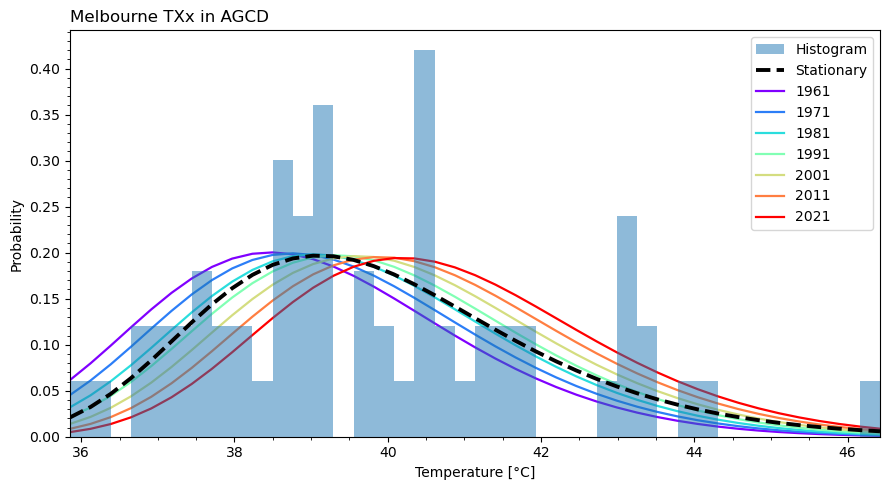

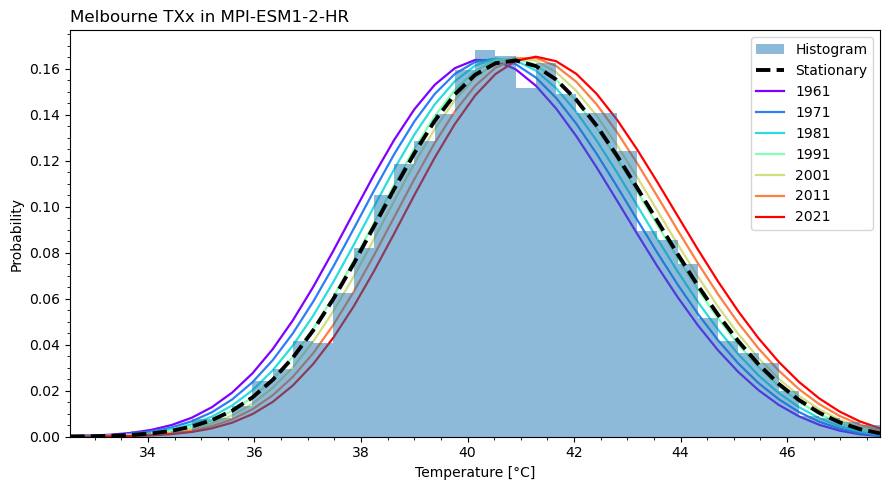

In [46]:
# AGCD PDFs
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
ax.set_title(f"{name} TXx in AGCD", loc="left")
ax = eva.plot_nonstationary_pdfs(ax, data_agcd, theta_s_agcd, theta_agcd, x)
ax.set_xlabel(f"Temperature [{data.attrs['units']}]")
ax.set_xmargin(0)
plt.tight_layout()
plt.show()

# Model PDFs
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
ax.set_title(f"{name} TXx in {model}", loc="left")
ax = eva.plot_nonstationary_pdfs(ax, da_stacked, theta_s, theta, x)
ax.set_xlabel(f"Temperature [{data.attrs['units']}]")
ax.set_xmargin(0)
plt.tight_layout()
plt.show()

In [323]:
# # Same as before, but combined
# fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
# # AGCD PDFs
# ax[0].set_title(f'{name} TXx in AGCD', loc='left')
# ax[0] = plot_nonstationary_pdfs(ax[0], data_agcd, theta_s_agcd, theta_agcd, x)

# plt.tight_layout()

# # Model PDFs
# ax[1].set_title(f'{name} TXx in {model}', loc='left')
# ax[1] = plot_nonstationary_pdfs(ax[1], da_stacked, theta_s, theta, x)
# for i in [0, 1]:
#     ax[i].set_xlabel(f"Temperature [{da.attrs['units']}]")
#     ax[i].set_xmargin(0)
# plt.tight_layout()

## Return curves


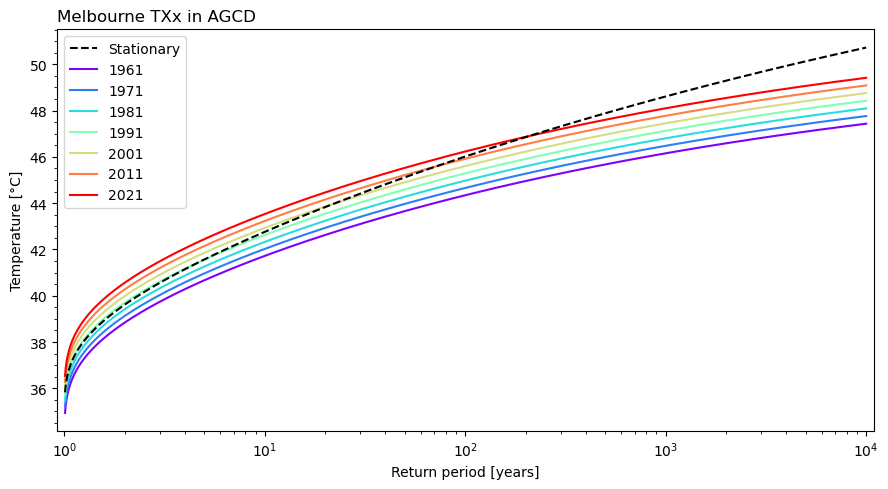

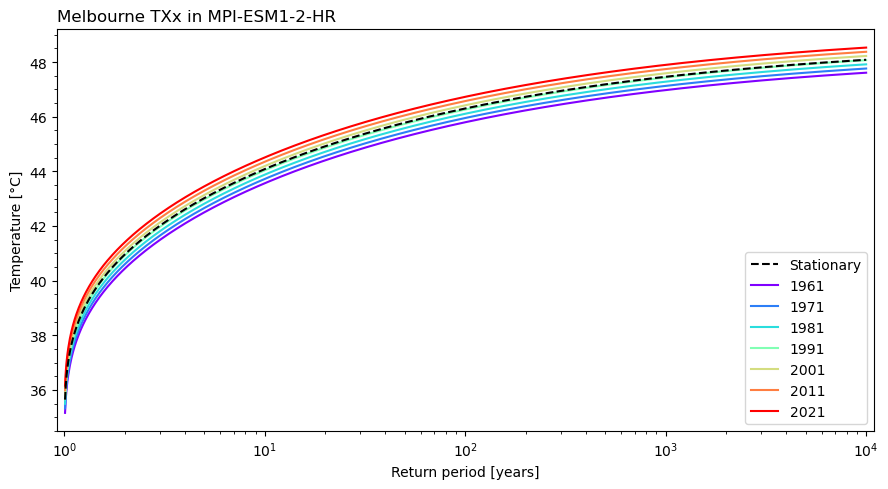

In [45]:
return_periods = xr.DataArray(np.logspace(0, 4, num=1000), dims="rp")

# AGCD return curves
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
plot_nonstationary_return_curve(ax, return_periods, theta_s_agcd, theta_agcd, x)
ax.set_title(f"{name} TXx in AGCD", loc="left")
ax.set_ylabel(f"Temperature [{data.attrs['units']}]")
ax.set_xmargin(1e-2)
plt.tight_layout()
plt.show()

# Model return curves
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
plot_nonstationary_return_curve(ax, return_periods, theta_s, theta, x)
ax.set_title(f"{name} TXx in {model}", loc="left")
ax.set_ylabel(f"Temperature [{data.attrs['units']}]")
ax.set_xmargin(1e-2)
plt.tight_layout()
plt.show()